In [120]:
# from https://www.tryexponent.com/courses/ml-engineer/ml-coding/predict-likelihood-app-delete

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt

In [121]:
df = pd.read_csv("predict_user_app_deletion.csv")

In [122]:
ori_df = df.copy()
ori_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,Label
0,US,M,17.0,E,1.0,3.0,10.0,45,2,17,1,I,17.0,2,1
1,UK,U,34.0,E,3.0,7.0,56.0,13,6,3,7,A,3.0,4,1
2,AR,NaN,19.0,P,1.0,9.0,12.0,45,7,12,4,A,5.0,2,0
3,NaN,NaN,87.0,NaN,NaN,NaN,NaN,4,5,1,5,I,NaN,2,0
4,NaN,F,NaN,P,NaN,6.0,19.0,9,12,8,6,NaN,NaN,2,0
5,US,M,17.0,E,1.0,3.0,10.0,45,2,17,1,I,12.0,2,1
6,UK,U,34.0,E,3.0,7.0,8.0,13,6,3,7,I,3.0,4,1
7,BR,NaN,19.0,P,1.0,9.0,2.0,5,7,12,4,A,5.0,2,1
8,NaN,M,6.0,NaN,NaN,NaN,NaN,4,5,1,5,I,NaN,2,0
9,IN,F,NaN,P,NaN,6.0,19.0,9,12,8,6,NaN,NaN,2,1


In [124]:
X = df.drop('Label', axis=1)
y = df['Label']

In [130]:
# (Step 3: Identify categorical and numerical columns)
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create the preprocessor with a nested pipeline for categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# Use SimpleImputer with strategy='most_frequent' for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# (Step 4 & 5: Create and fit the full pipeline)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=500,        # Number of boosting rounds
        learning_rate=0.05,      # Step size shrinkage to prevent overfitting
        max_depth=5,             # Maximum depth of a tree
        subsample=0.8,           # Fraction of samples to be used for each tree
        colsample_bytree=0.8,    # Fraction of features to be used for each tree
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
model_pipeline.fit(X_train, y_train)

/Users/mikec/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['F3', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F13', 'F14'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])


Model Accuracy on the test set: 0.50
Average Precision-Recall Score: 0.50
[0.5 1. ] [1. 0.] [0.63784206]
y_test=
8    0
1    1
Name: Label, dtype: int64
y_scores=
[0.63784206 0.63784206]
y_pred=
[1 1]


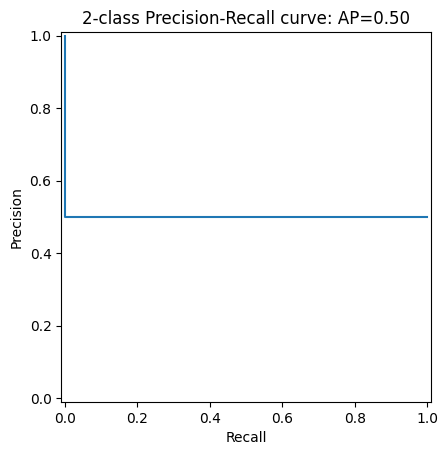

In [132]:
# (Step 6: Evaluate the model)
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy on the test set: {accuracy:.2f}")

y_scores = model_pipeline.predict_proba(X_test)[:, 1]

# precision: The last element of this array is always 1.0, which corresponds to 
#     the case where no positive predictions are made (and thus no false positives).
# recall: The last element of this array is always 0.0, which corresponds to the 
#     case where no positive predictions are made (and thus no true positives are found).
# thresholds: The number of thresholds is one less than the number of precision 
#     and recall values.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Compute the Area Under the Precision-Recall Curve (average precision)
avg_precision = average_precision_score(y_test, y_scores)
print(f"Average Precision-Recall Score: {avg_precision:.2f}")

print(precision, recall, thresholds)
print(f"y_test=\n{y_test}")
print(f"y_scores=\n{y_scores}")
print(f"y_pred=\n{y_pred}")

# Plot the precision-recall curve
display = PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()
plt.title(f'2-class Precision-Recall curve: AP={avg_precision:.2f}')
plt.show()
